<a href="https://colab.research.google.com/github/pavel7479/For_resume/blob/main/CarDetection_YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# команда для вывода информации о видеокарте
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install ultralytics==8.0.227

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 28.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os # импортируем библиотеку для взаимодействия с операционной системой
import shutil
import random
import cv2 # импортируем библиотеку для работы с изображениями
import random # импортируем библиотеку для генерации рандомных данных
import numpy as np # импортируем библиотеку линейной алгебры
import matplotlib.pyplot as plt # импортируем библиотеку для визуализации данных
import json
from PIL import Image, ImageDraw # импортируем модуль для работы с изображениями
from zipfile import ZipFile # импортируем класс для работы с zip архивами
from ultralytics import YOLO # импортируем класс модели
from ultralytics.engine.results import Results # импортируем класс результата, возвращаемого в списке после предикта
from typing import Sequence, Generator, Literal, TypeAlias # импортируем дополнительные типы для лучшей читаемости кода


Mounted at /content/drive


# Функции

In [ ]:

def convert_bbox_to_yolo(image_size, bbox):
    """
    Преобразование координат bounding box из формата [x, y, width, height] в формат YOLO.
    """
    x_center, y_center, w, h = bbox
    dw = 1. / image_size[0]
    dh = 1. / image_size[1]
    x_center = x_center * dw
    y_center = y_center * dh
    w = w * dw
    h = h * dh
    return (x_center, y_center, w, h)

def draw_yolo_bbox_on_image(image_path, yolo_bbox):
    """
    Отрисовка bounding box на изображении по координатам YOLO.
    """
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    img_width, img_height = image.size

    # Преобразуем YOLO bbox обратно в координаты [left, top, right, bottom]
    x_center, y_center, w, h = yolo_bbox
    x_center *= img_width
    y_center *= img_height
    w *= img_width
    h *= img_height

    left = x_center - w / 2
    top = y_center - h / 2
    right = x_center + w / 2
    bottom = y_center + h / 2

    # Отрисовка прямоугольника
    draw.rectangle([left, top, right, bottom], outline="red", width=3)

    # Возвращаем изображение с нарисованным bbox
    return image




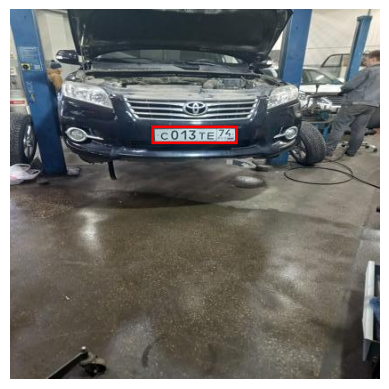

In [ ]:
# @title Проверка разметки

image_path = '/content/drive/MyDrive/Стажировка2/bboxes/images/foto_test7.jpg'
json_path = '/content/drive/MyDrive/Стажировка2/bboxes/json/foto_test7_bboxes.json'

# Загружаем bounding box из JSON
with open(json_path, 'r') as f:
    data = json.load(f)
    bbox = data['bboxes'][0]  # Предположим, что в JSON один bbox

# Преобразуем bbox в формат YOLO
image = Image.open(image_path)
yolo_bbox = convert_bbox_to_yolo(image.size, bbox)

# Отрисовываем bbox на изображении
image_with_bbox = draw_yolo_bbox_on_image(image_path, yolo_bbox)

# Преобразуем изображение в массив numpy
image_np = np.array(image_with_bbox)

# Убедимся, что данные изображения имеют тип uint8, который подходит для matplotlib
image_np = image_np.astype(np.uint8)

# Отображаем изображение с bbox с использованием matplotlib
plt.imshow(image_np)
plt.axis('off')  # Убираем оси
plt.show()


In [ ]:
# @title Преобразование всех JSON файлов в YOLO разметку

def create_yolo_labels(json_folder, images_folder, output_folder):
    """
    Преобразование всех JSON файлов в YOLO разметку.
    """
    print(f"Начало работы функции: json_folder={json_folder}, images_folder={images_folder}, output_folder={output_folder}")

    # Проверяем, существуют ли папки
    if not os.path.exists(json_folder):
        print(f"Папка с JSON файлами не существует: {json_folder}")
        return

    if not os.path.exists(images_folder):
        print(f"Папка с изображениями не существует: {images_folder}")
        return

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Создана папка для вывода: {output_folder}")

    # Проходим по всем JSON файлам в папке
    for json_file in os.listdir(json_folder):
        print(f"Проверка файла: {json_file}")
        if json_file.endswith('.json'):
            json_path = os.path.join(json_folder, json_file)
            print(f"Обработка JSON файла: {json_path}")
            with open(json_path, 'r') as f:
                data = json.load(f)

            image_name = data.get('image')
            if not image_name:
                print(f"Поле 'image' не найдено в {json_path}, пропуск...")
                continue

            image_path = os.path.join(images_folder, image_name)

            # Проверка наличия изображения
            if not os.path.exists(image_path):
                print(f"Изображение {image_path} не найдено, пропуск...")
                continue

            print(f"Открытие изображения: {image_path}")
            image = Image.open(image_path)
            image_size = image.size  # (width, height)
            print(f"Размер изображения: {image_size}")

            bboxes = data.get('bboxes', [])
            if not bboxes:
                print(f"Поле 'bboxes' пустое или отсутствует в {json_path}, пропуск...")
                continue

            yolo_labels = []
            for bbox in bboxes:
                yolo_bbox = convert_bbox_to_yolo(image_size, bbox)
                # Предположим, что class_id = 0 для всех номеров машин
                yolo_labels.append(f"0 {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}")

            # Сохранение в файл с таким же именем, что и изображение, но с расширением .txt
            label_filename = os.path.splitext(image_name)[0] + '.txt'
            label_path = os.path.join(output_folder, label_filename)
            with open(label_path, 'w') as label_file:
                label_file.write('\n'.join(yolo_labels))

            print(f"Сохранен файл разметки: {label_path}")



In [ ]:
# Папки с исходными данными
json_folder = '/content/drive/MyDrive/Стажировка2/bboxes/json'
images_folder = '/content/drive/MyDrive/Стажировка2/bboxes/images'
output_folder = '/content/drive/MyDrive/Стажировка2/bboxes/yolo/labels'

create_yolo_labels(json_folder, images_folder, output_folder)

Начало работы функции: json_folder=/content/drive/MyDrive/Стажировка2/bboxes/json, images_folder=/content/drive/MyDrive/Стажировка2/bboxes/images, output_folder=/content/drive/MyDrive/Стажировка2/bboxes/yolo/labels
Проверка файла: foto_test798_bboxes.json
Обработка JSON файла: /content/drive/MyDrive/Стажировка2/bboxes/json/foto_test798_bboxes.json
Открытие изображения: /content/drive/MyDrive/Стажировка2/bboxes/images/foto_test798.jpg
Размер изображения: (416, 416)
Сохранен файл разметки: /content/drive/MyDrive/Стажировка2/bboxes/yolo/labels/foto_test798.txt
Проверка файла: foto_test298_bboxes.json
Обработка JSON файла: /content/drive/MyDrive/Стажировка2/bboxes/json/foto_test298_bboxes.json
Открытие изображения: /content/drive/MyDrive/Стажировка2/bboxes/images/foto_test298.jpg
Размер изображения: (416, 416)
Сохранен файл разметки: /content/drive/MyDrive/Стажировка2/bboxes/yolo/labels/foto_test298.txt
Проверка файла: foto_test319_bboxes.json
Обработка JSON файла: /content/drive/MyDrive/С

In [ ]:
import os
import shutil

In [ ]:
# Сортировка файлов по папкам

# Укажите путь к папке, где лежат файлы
source_folder = '/content/drive/MyDrive/Стажировка2/bboxes'

# Укажите пути для новых папок
jpg_folder = os.path.join(source_folder, 'json')
json_folder = os.path.join(source_folder, 'images')

# Создаем новые папки
os.makedirs(jpg_folder, exist_ok=True)
os.makedirs(json_folder, exist_ok=True)

# Перебираем все файлы в исходной папке
for filename in os.listdir(source_folder):
    # Полный путь к файлу
    file_path = os.path.join(source_folder, filename)

    # Если это файл с расширением .jpg
    if filename.endswith('.jpg'):
        # Перемещаем его в папку jpg_files
        shutil.move(file_path, jpg_folder)

    # Если это файл с расширением .json
    elif filename.endswith('.json'):
        # Перемещаем его в папку json_files
        shutil.move(file_path, json_folder)

print("Файлы перемещены!")


Файлы перемещены!


In [ ]:

# Корневая папка для набора данных
dataset_folder = "/content/drive/MyDrive/Стажировка2/dataset"

# Папки для изображений
train_images_folder = os.path.join(dataset_folder, "images", "train")
val_images_folder = os.path.join(dataset_folder, "images", "val")

# Папки для файлов разметки (labels)
train_labels_folder = os.path.join(dataset_folder, "labels", "train")
val_labels_folder = os.path.join(dataset_folder, "labels", "val")

# Создание всех папок
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)

print(f"Создана структура каталогов в '{os.path.abspath(dataset_folder)}'")


Создана структура каталогов в '/content/drive/MyDrive/Стажировка2/dataset'


In [ ]:
# @title Перемещение файлов по каталогам по требованиями YOLO

# Настройки
images_folder = "/content/drive/MyDrive/Стажировка2/bboxes/images"  # Путь к папке с исходными изображениями
labels_folder = "/content/drive/MyDrive/Стажировка2/bboxes/yolo/labels"  # Путь к папке с исходными текстовыми файлами (YOLO labels)
output_folder = "/content/drive/MyDrive/Стажировка2/dataset"  # Путь к корневой папке созданной структуры

# Соотношение для разделения
train_ratio = 0.8

# Список всех изображений
all_images = [f for f in os.listdir(images_folder) if f.endswith('.jpg')]
random.shuffle(all_images)  # Перемешиваем для случайного распределения

# Определяем количество файлов для train и val
num_train = int(len(all_images) * train_ratio)
train_images = all_images[:num_train]
val_images = all_images[num_train:]

# Функция для перемещения файлов
def move_files(image_list, dest_images_folder, dest_labels_folder):
    for image_name in image_list:
        # Перемещение изображений
        src_image_path = os.path.join(images_folder, image_name)
        dest_image_path = os.path.join(dest_images_folder, image_name)
        shutil.copy(src_image_path, dest_image_path)

        # Перемещение соответствующих текстовых файлов с метками
        label_name = os.path.splitext(image_name)[0] + '.txt'
        src_label_path = os.path.join(labels_folder, label_name)
        dest_label_path = os.path.join(dest_labels_folder, label_name)

        # Проверка на наличие соответствующего текстового файла
        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dest_label_path)

# Перемещаем файлы для train
train_images_folder = os.path.join(output_folder, "images", "train")
train_labels_folder = os.path.join(output_folder, "labels", "train")
move_files(train_images, train_images_folder, train_labels_folder)

# Перемещаем файлы для val
val_images_folder = os.path.join(output_folder, "images", "val")
val_labels_folder = os.path.join(output_folder, "labels", "val")
move_files(val_images, val_images_folder, val_labels_folder)

print("Файлы успешно распределены по структуре каталогов.")


Файлы успешно распределены по структуре каталогов.


In [ ]:
dataset_yaml = """
train: /content/drive/MyDrive/Стажировка2/dataset/images/train
val: /content/drive/MyDrive/Стажировка2/dataset/images/val

nc: 1
names: ['license_plate']
"""

with open('/content/drive/MyDrive/Стажировка2/dataset/dataset.yaml', 'w') as file:
    file.write(dataset_yaml)

print("Файл dataset.yaml успешно создан и сохранен в папку dataset/")


Файл dataset.yaml успешно создан и сохранен в папку dataset/


# Обучение

In [ ]:

# Создание модели
model = YOLO('yolov8n.pt')  # Используйте 'yolov8s.pt' или другой вариант в зависимости от потребностей

# Начало обучения
model.train(data='/content/drive/MyDrive/Стажировка2/dataset/dataset.yaml', epochs=50, imgsz=640, save=True, save_period=1, save_best=True)


100%|██████████| 6.23M/6.23M [00:00<00:00, 158MB/s]

New https://pypi.org/project/ultralytics/8.2.85 available 😃 Update with 'pip install -U ultralytics'



/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Стажировка2/dataset/dataset.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

100%|██████████| 755k/755k [00:00<00:00, 30.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


WARNING ⚠️ NMS time limit 0.550s exceeded


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/checks.py:596: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):


AMP: checks passed ✅


/usr/local/lib/python3.10/dist-packages/ultralytics/engine/trainer.py:237: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /content/drive/MyDrive/Стажировка2/dataset/labels/train... 941 images, 0 backgrounds, 0 corrupt: 100%|██████████| 941/941 [01:38<00:00,  9.60it/s]


train: New cache created: /content/drive/MyDrive/Стажировка2/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/Стажировка2/dataset/labels/val... 465 images, 0 backgrounds, 0 corrupt: 100%|██████████| 465/465 [02:19<00:00,  3.35it/s]


val: New cache created: /content/drive/MyDrive/Стажировка2/dataset/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.23G     0.9707      2.342      1.174         17        640: 100%|██████████| 59/59 [00:24<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

                   all        465        472      0.321     0.0973      0.135      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G     0.7995      1.514      1.044         17        640: 100%|██████████| 59/59 [00:21<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.56it/s]


                   all        465        472      0.403      0.398      0.209      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.15G     0.7304      1.372      1.024         22        640: 100%|██████████| 59/59 [00:23<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

                   all        465        472      0.402      0.404       0.24      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.15G     0.6236      1.168     0.9576         20        640: 100%|██████████| 59/59 [00:21<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.63it/s]

                   all        465        472      0.387      0.407      0.244      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.15G     0.5595      1.038     0.9471         24        640: 100%|██████████| 59/59 [00:21<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


                   all        465        472      0.409      0.409      0.291      0.233

5 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


                   all        465        472      0.409      0.409      0.291      0.233
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5b70d3a650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

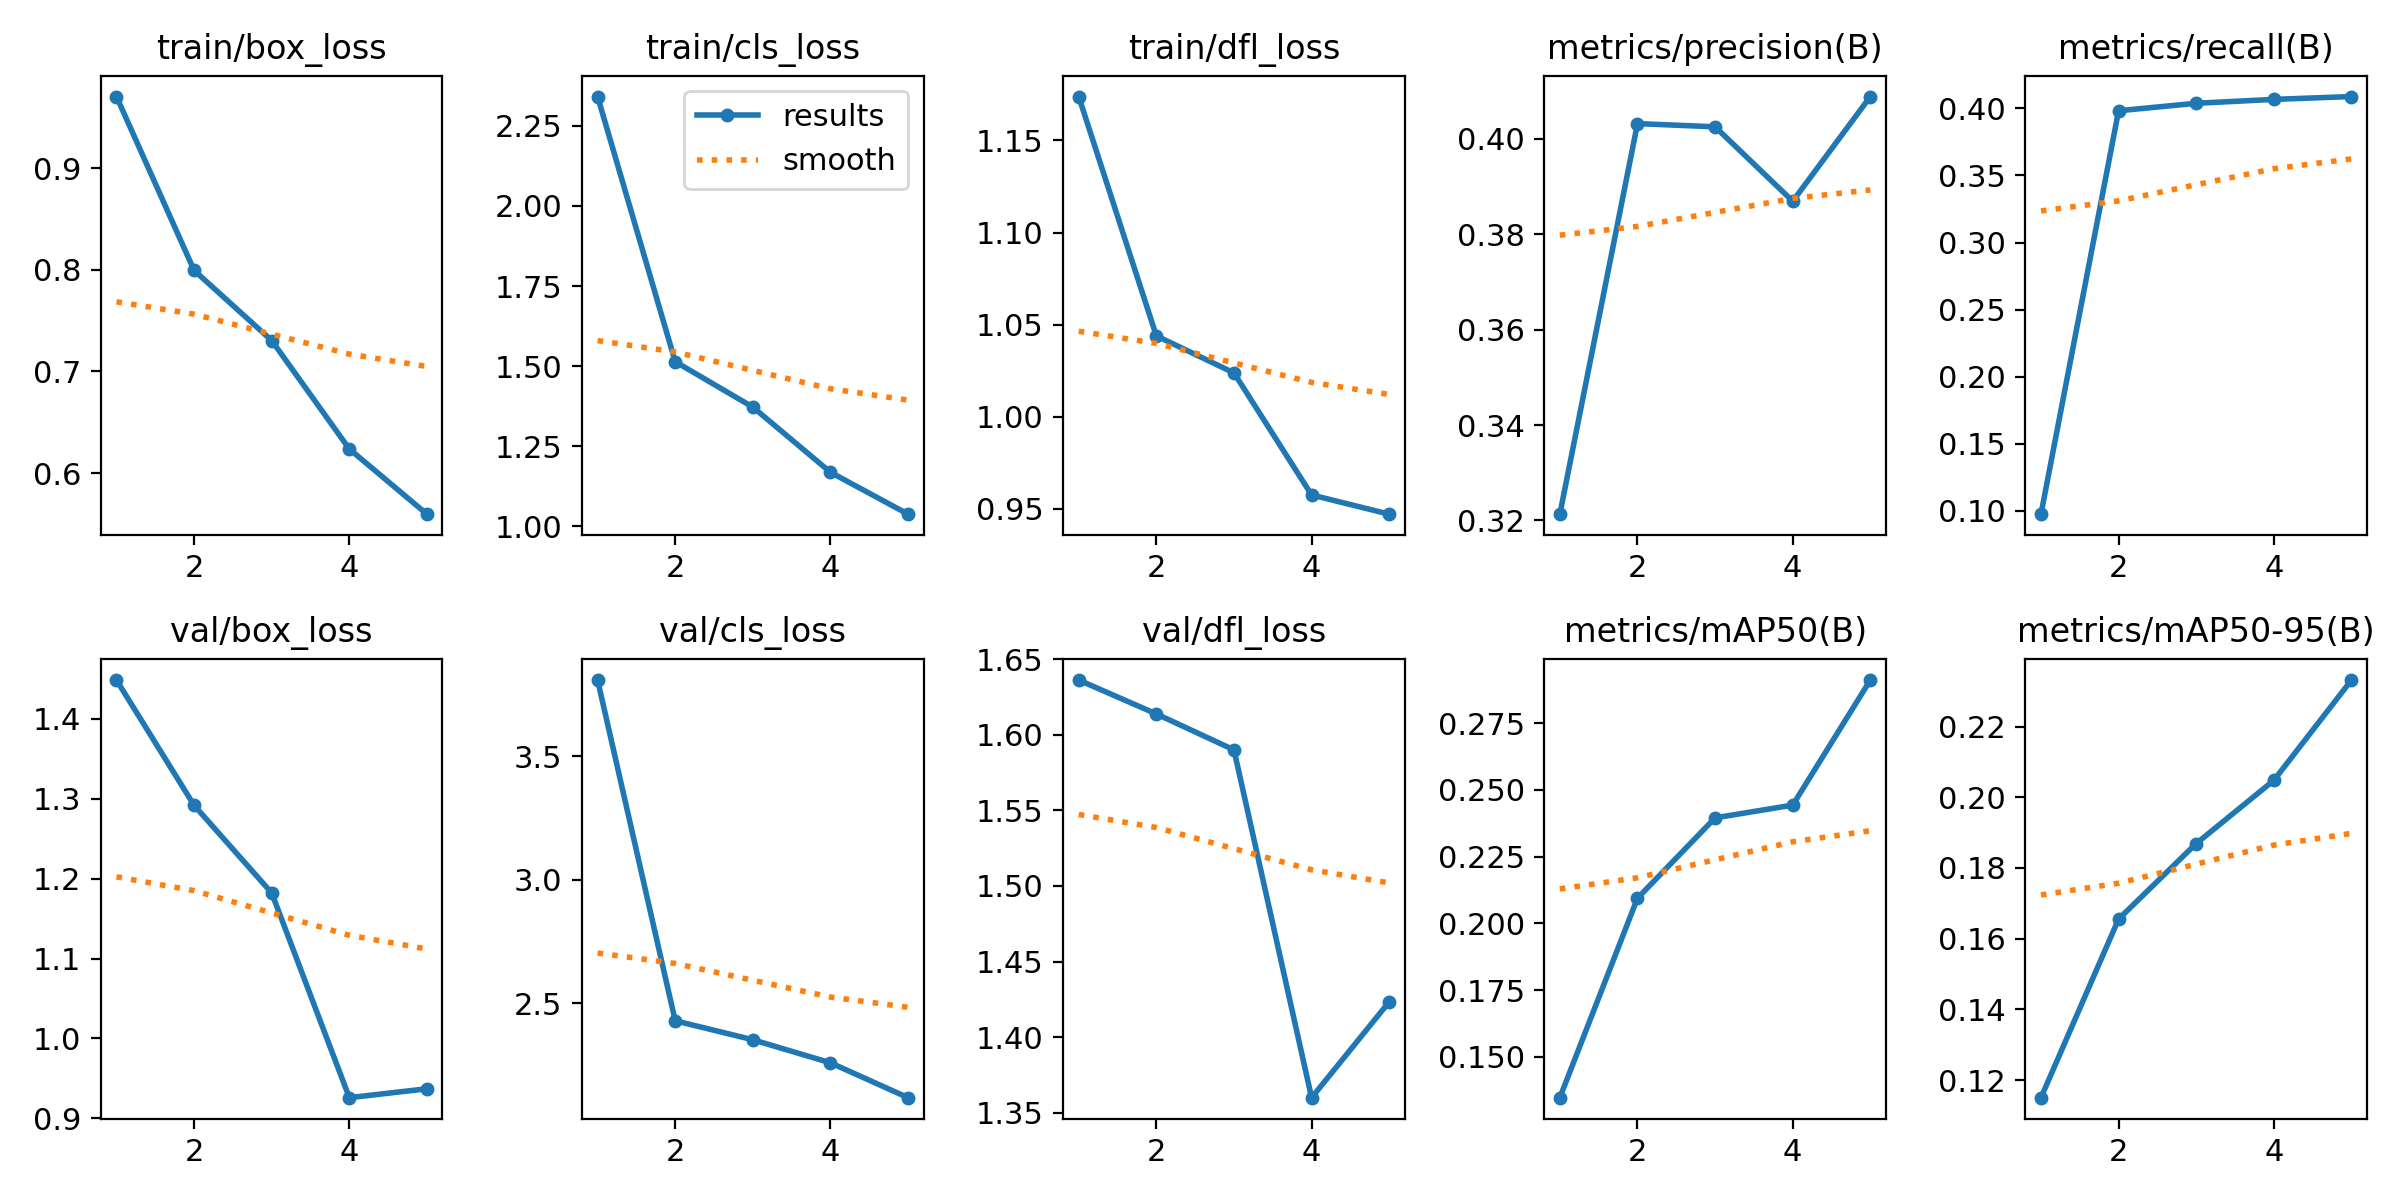

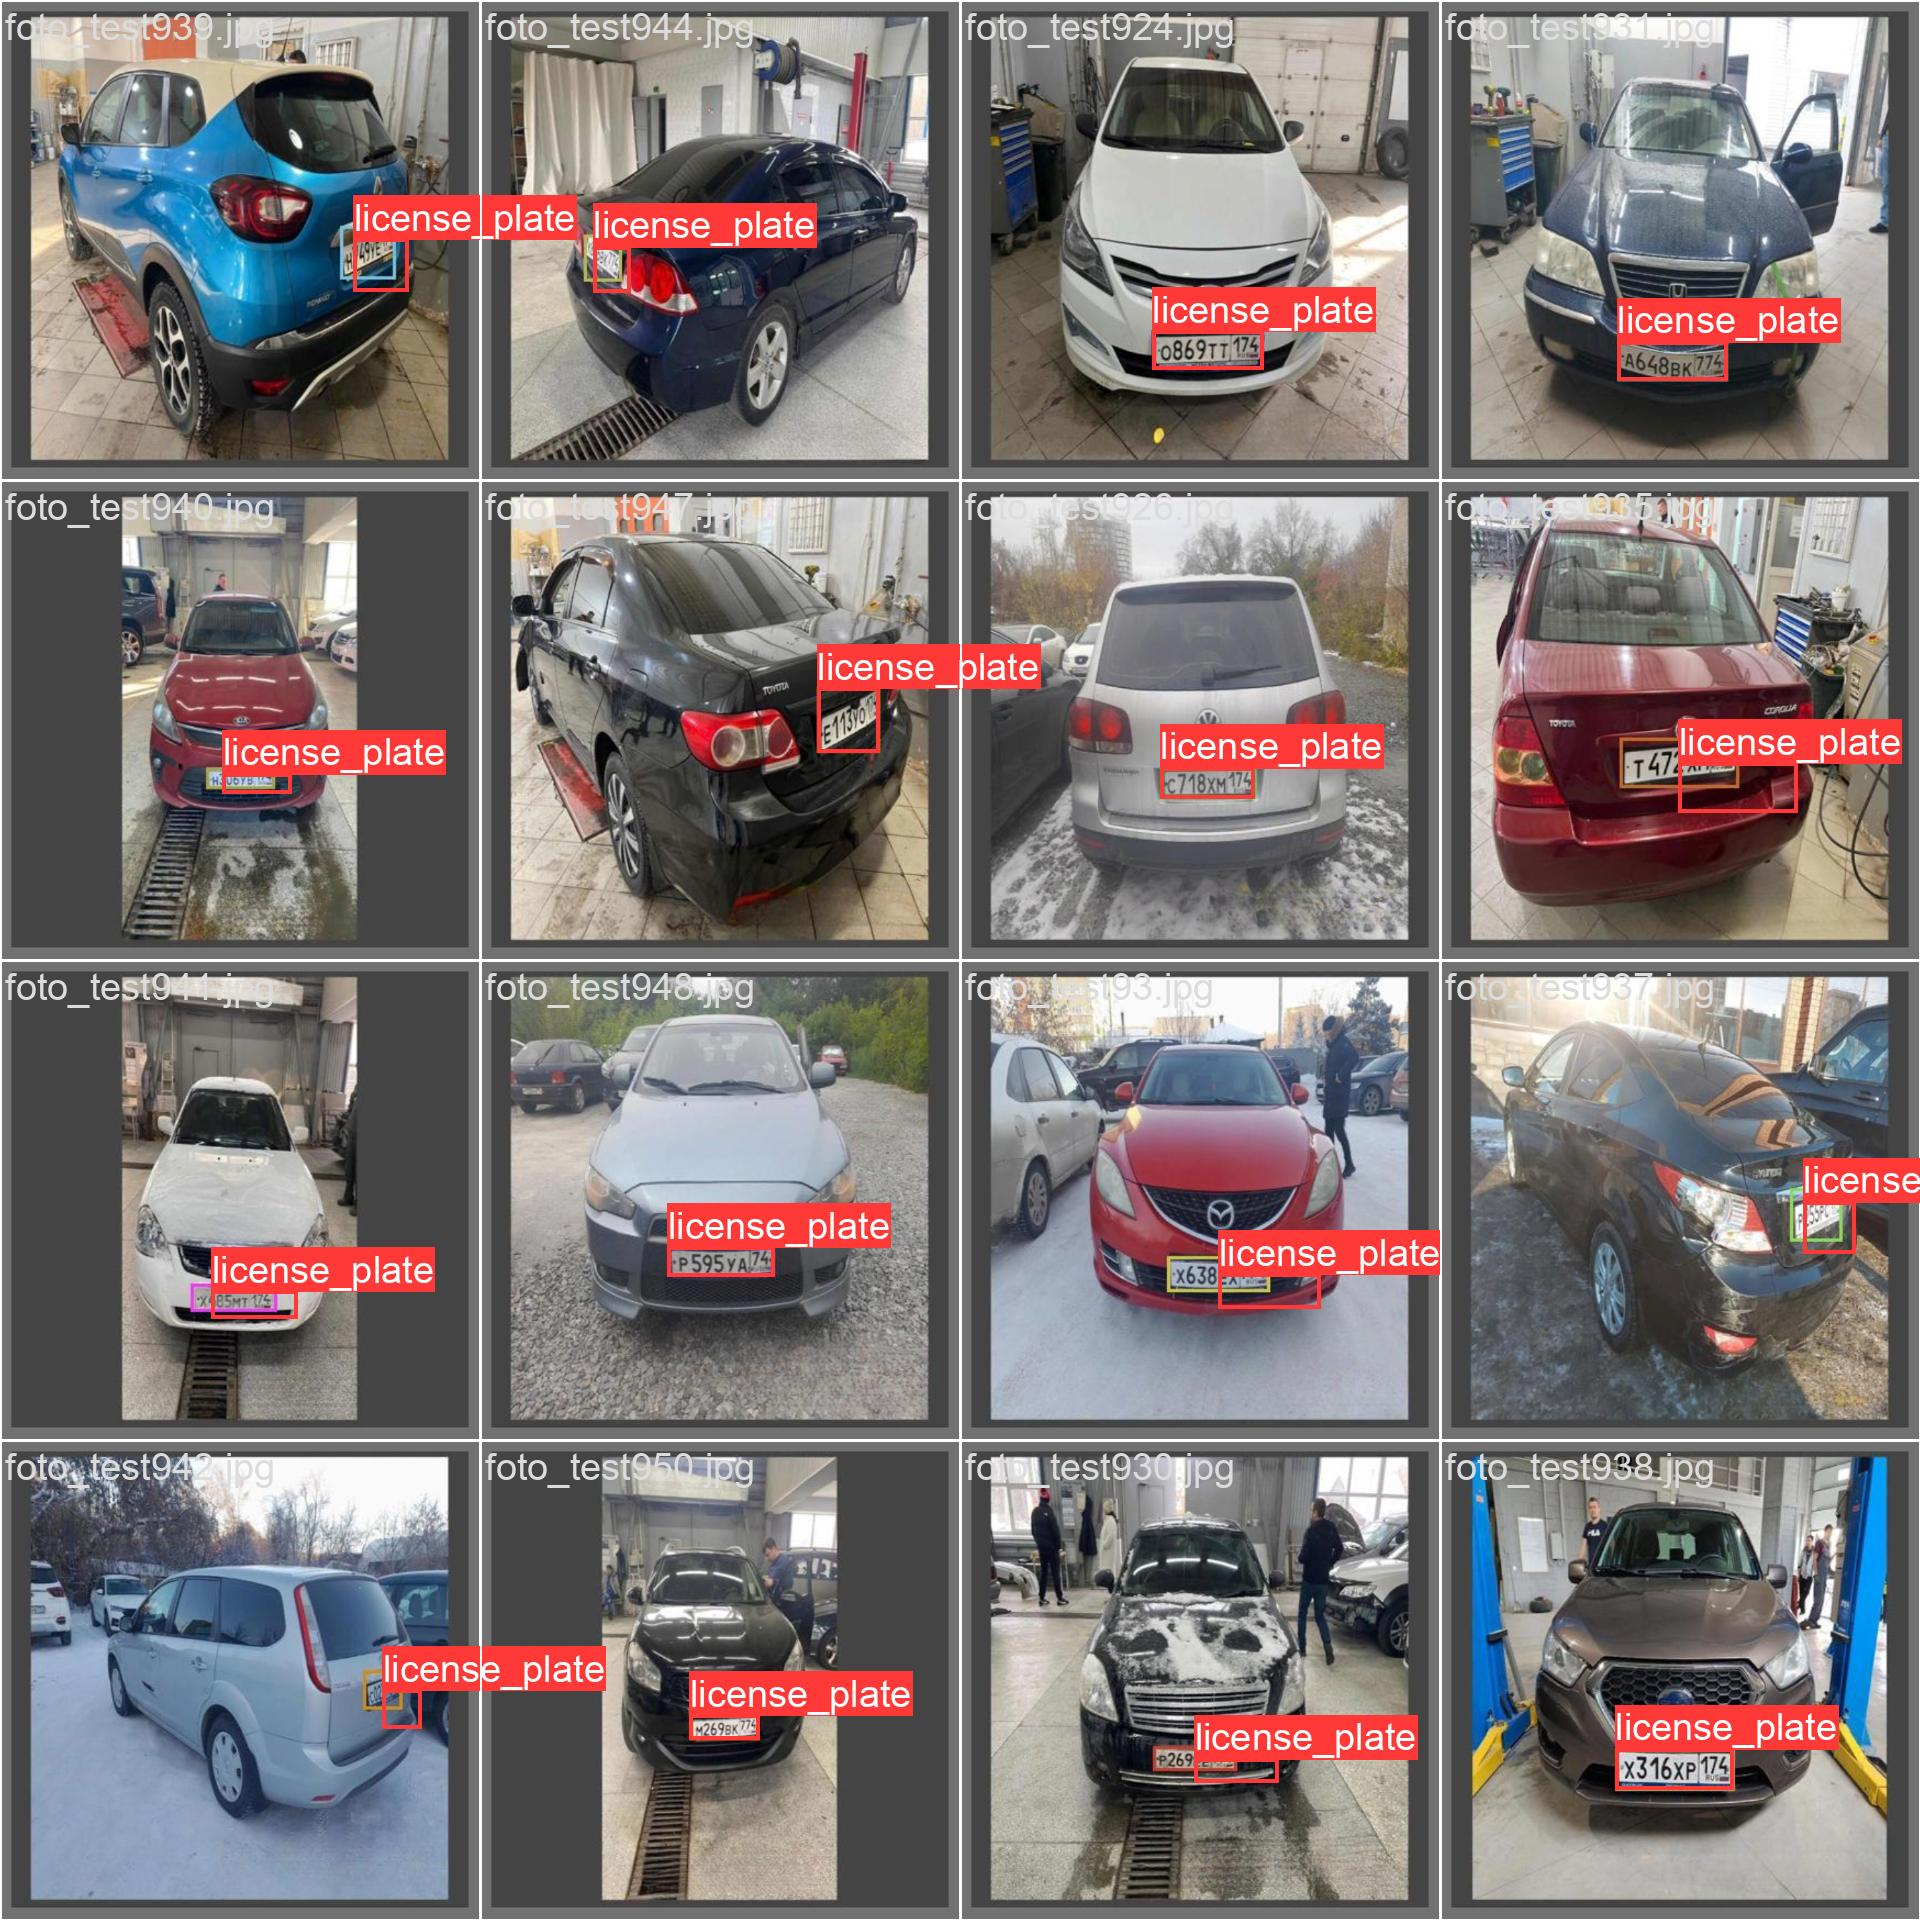

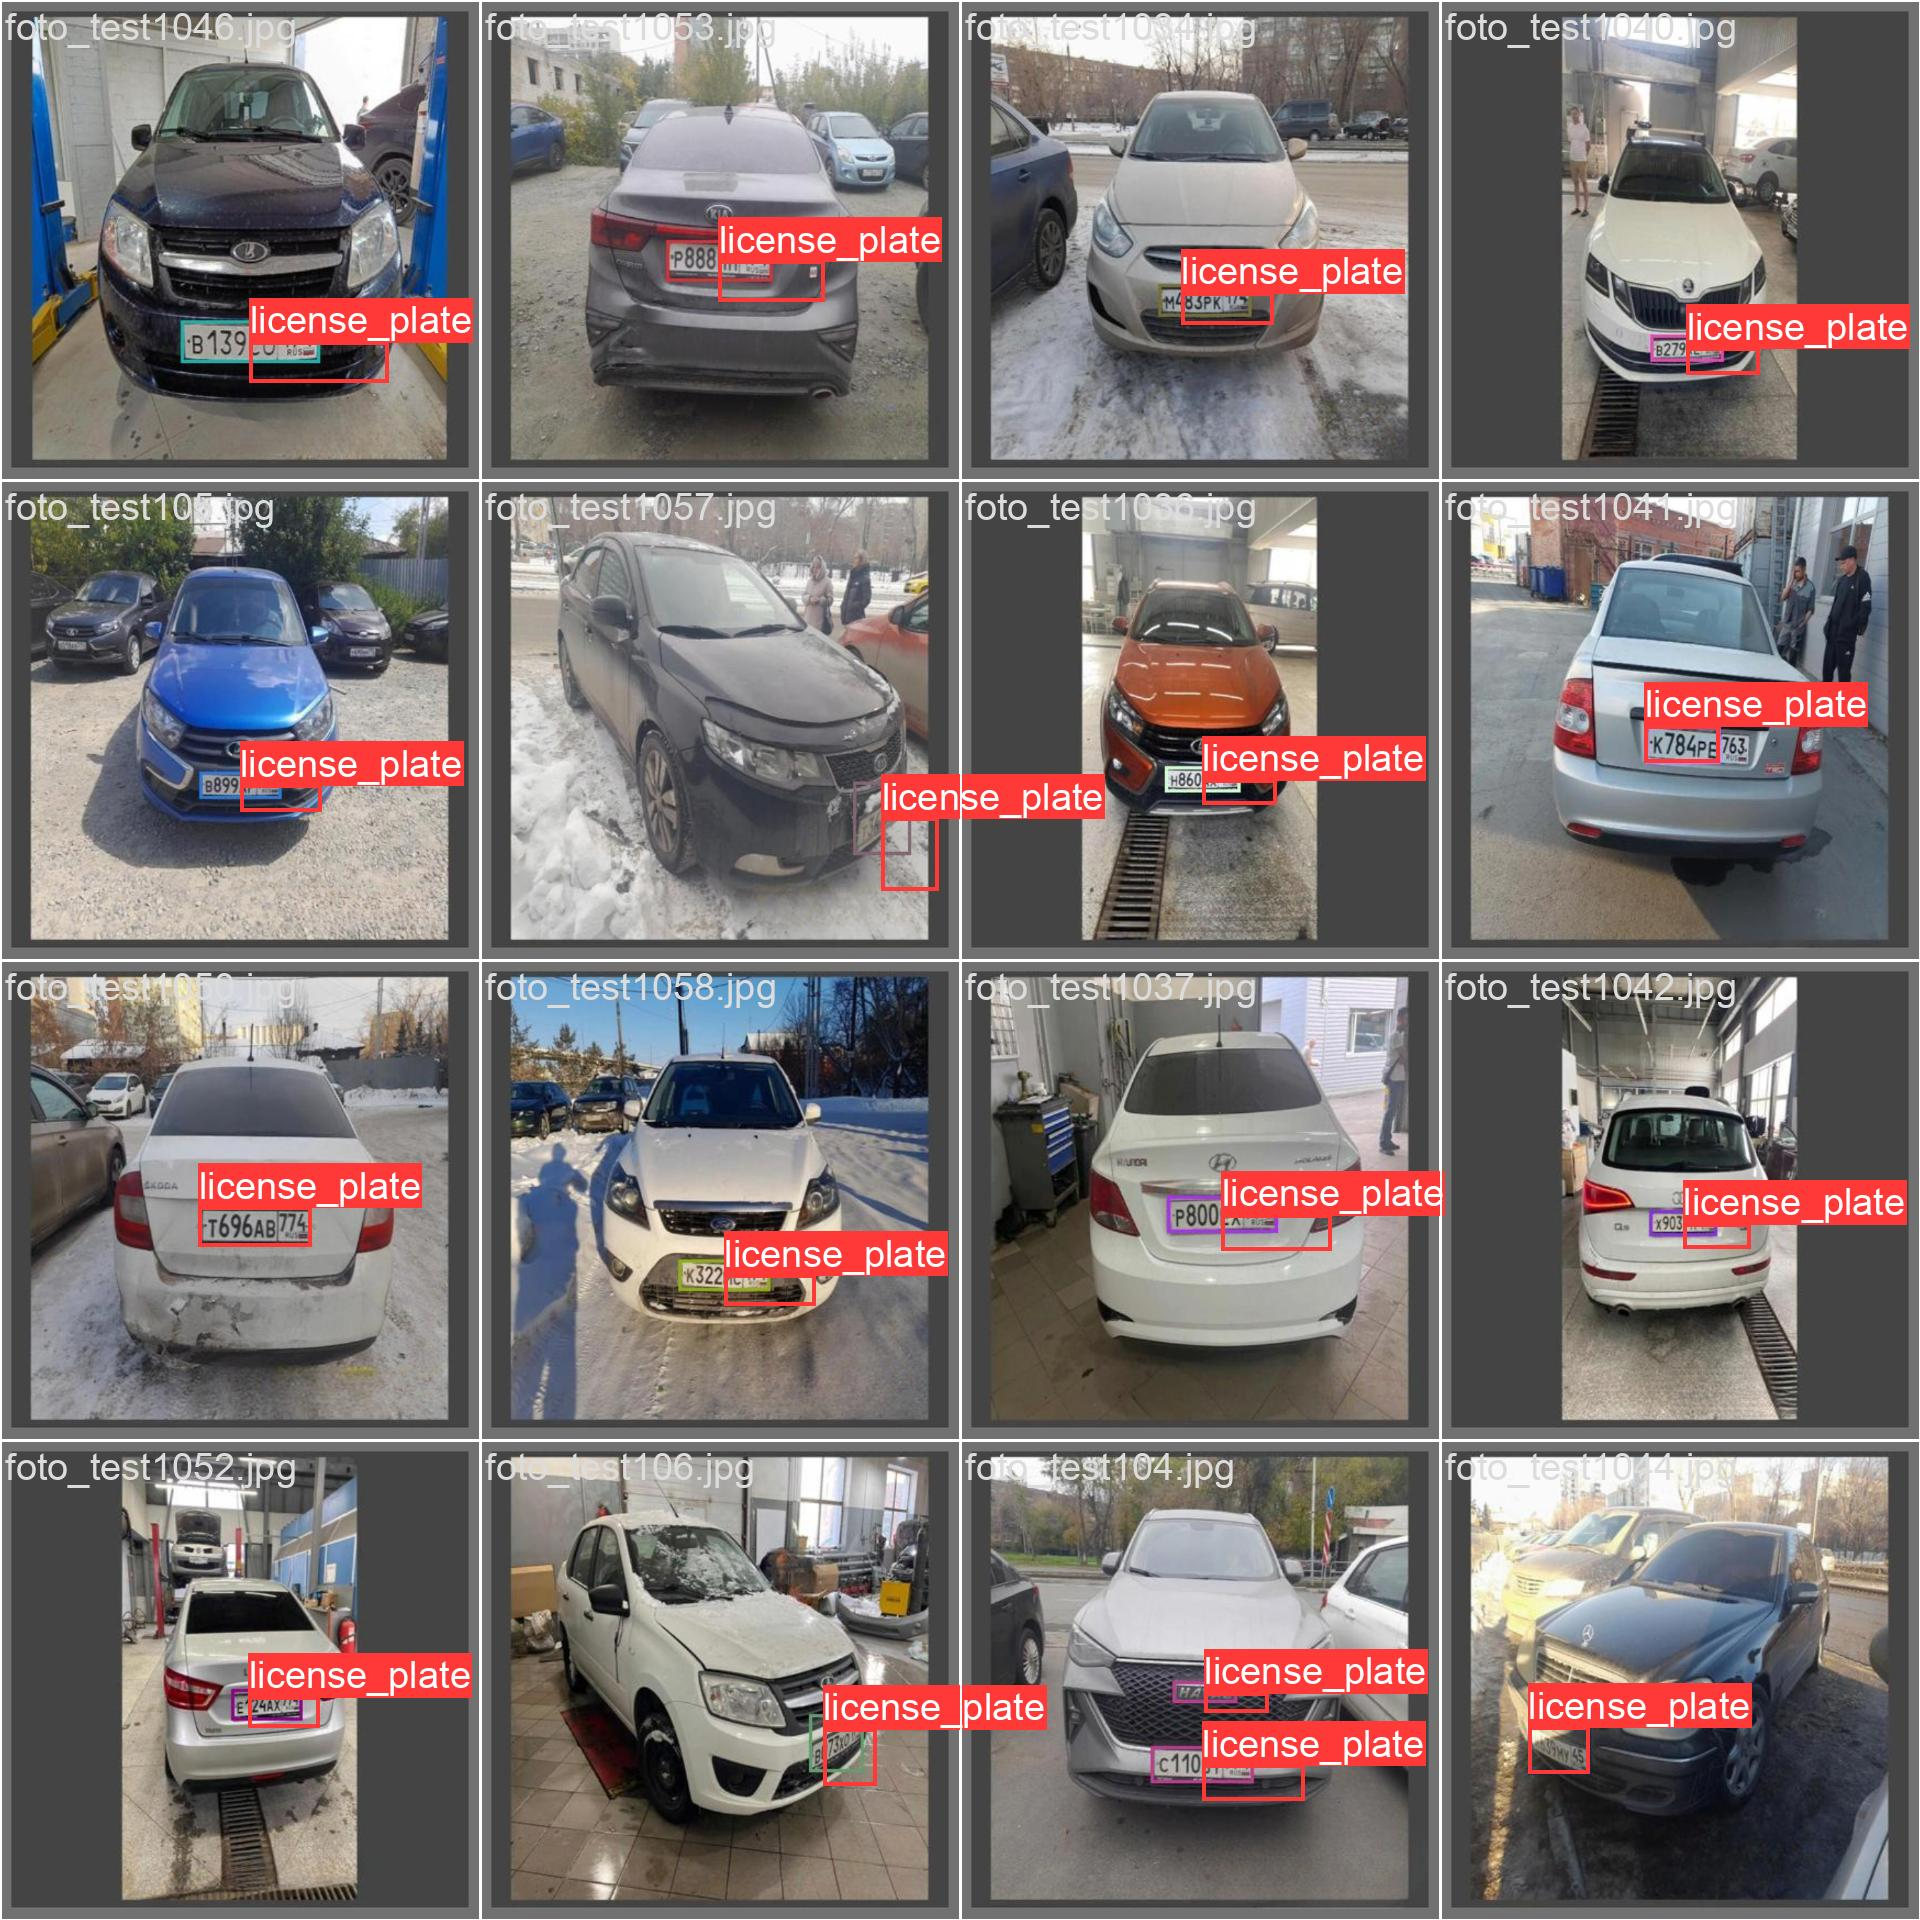

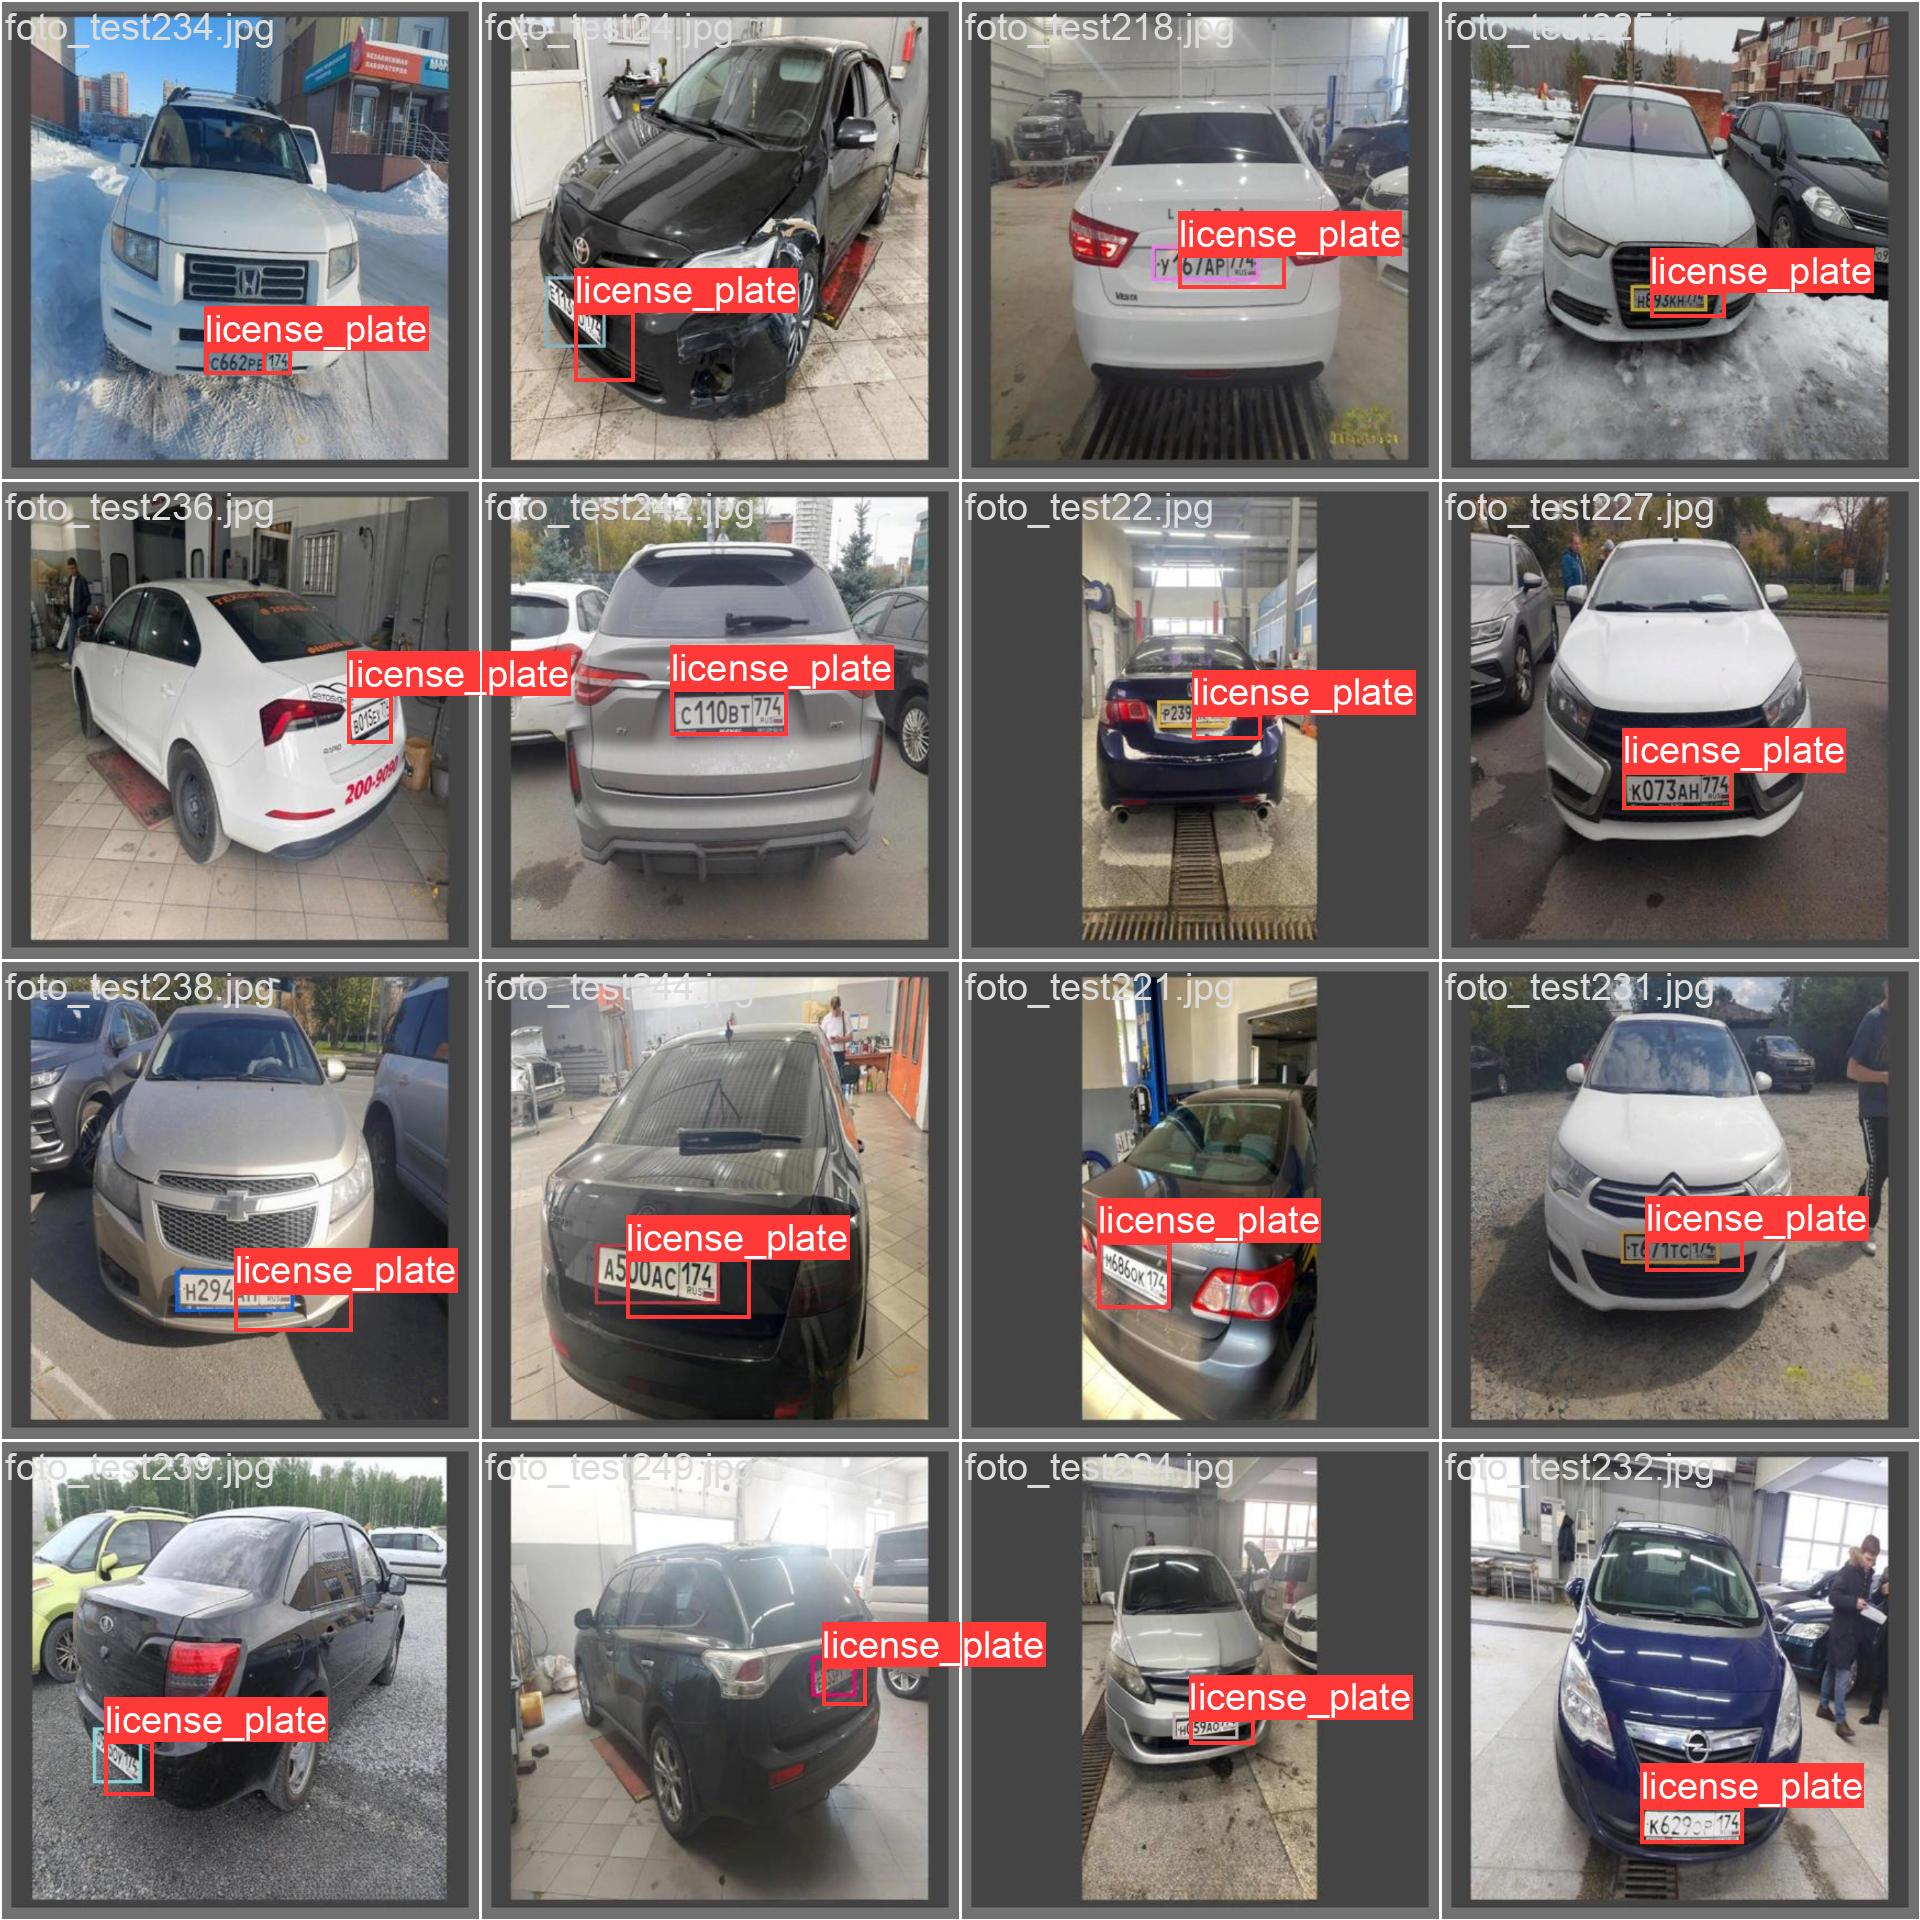

In [ ]:
from IPython.display import Image, display

# Отображение графиков обучения
display(Image(filename='runs/detect/train/results.png'))

# Отображение изображений из валидационного набора
for i in range(3):  # Отображение первых 3 изображений
    display(Image(filename=f'runs/detect/train/val_batch{i}_labels.jpg'))
